In [2]:
import sys, os

if 'COLAB_GPU' in os.environ:
    print("Running on Google Colab, setting up environment")
    colab = True
    !pip install scikit-video

    !mkdir -p ./src/data  
    !mkdir -p ./src/modules  
    !mkdir -p ./data
    !mkdir -p ./models

    !wget -P ./src/data https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/data/build_features.py
    !wget -P ./src/data https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/data/compute_surprise.py
    !wget -P ./src/data https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/data/load_pose_data.py
    !wget -P ./src/data https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/data/merge_data_sets.py
    !wget -P ./src/data https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/data/preprocess_pose_data.py


    !wget -P  ./src/modules https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/modules/circstats.py
    !wget -P  ./src/modules https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/modules/skeleton.py
    !wget -P  ./src/modules https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/modules/util_data.py
    !wget -P  ./src/modules https://raw.githubusercontent.com/quietscientist/Infant_movement_assessment/master/src/modules/util_vis.py

    sys.path.insert(0,'./src/data')
    sys.path.insert(0,'./src/modules')

    data_path = './data'
    model_path = './models'
    home_path = './'

else: 
    colab = False
    sys.path.insert(0,'../src/data')
    sys.path.insert(0,'../src/modules')

    data_path = '../data'
    model_path = '../models'
    home_path = '../'

In [3]:
import pandas as pd
from scipy.stats import norm
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import pickle as pkl


import load_pose_data
import skvideo.io
import itertools
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.linalg import svd
import preprocess_pose_data, build_features, merge_data_sets, compute_surprise
import  util_vis
from util_vis import plot_skel, gen_one_frame, get_one_frame, normm

from skeleton import Skeleton

In [4]:
def setup_env():
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(model_path):
        os.makedirs(model_path)

    #if data directory is empty, rerun setup 
    if not os.path.exists(data_path) or len(os.listdir(data_path)) == 0:

        if colab:
            !wget https://figshare.com/ndownloader/files/15593963?private_link=10034c230ad9b2b2a6a4 -O ./pose_data.zip
            !unzip -o ./pose_data.zip -d ./


            !mv --force ./infant_movement_assessment_repo_files/data/* ./data
            !mv --force ./infant_movement_assessment_repo_files/models/* ./models

            !rm ./pose_data.zip
            !rm -r ./infant_movement_assessment_repo_files

        else:
            !wget https://figshare.com/ndownloader/files/15593963?private_link=10034c230ad9b2b2a6a4 -O ../pose_data.zip
            !unzip -o ../pose_data.zip -d ../


            !mv --force ../infant_movement_assessment_repo_files/data/* ../data
            !mv --force ../infant_movement_assessment_repo_files/models/* ../models

            !rm ../pose_data.zip
            !rm -r ../infant_movement_assessment_repo_files
    else: 
        print('setup for this project has already been done. Skipping download and extraction of data.')

def compute_kinematics(datasets, data_path):
    for data_set in data_sets:
        print(f'Processing {data_set} data set')

        raw_pose_estimates_video_path = f'{data_path}/pose_estimates/{data_set}/py/pose_estimates.pkl'
        assert os.path.exists(raw_pose_estimates_video_path), 'Folder does not exist. \n Edit path to pose estimate data (raw_pose_estimates_video_path) in notebooks/infant_move/master.ipynb, Cell 2.'

        #load_pose_data.main(data_set, raw_pose_estimates_video_path)
        preprocess_pose_data.main(data_set, data_path)
        build_features.main(data_set, data_path)


In [5]:
def reorder_keypoints(keypoints):
    """
    Reorder the keypoints to the OpenPose format.
    The OpenPose format is as follows:
    0-17: [nose, neck, right_shoulder, right_elbow, right_wrist, left_shoulder, left_elbow, left_wrist,
           right_hip, right_knee, right_ankle, left_hip, left_knee, left_ankle, right_eye, left_eye, right_ear, left_ear]
    The input 'keypoints' is a list of (x, y, c) tuples, where c is the confidence score.
    """

    # Reorder the keypoints to the OpenPose format
    keypoints = [keypoints[i] for i in [0, 17, 6, 8, 10, 5, 7, 9, 12, 14, 16, 11, 13, 15, 2, 1, 4, 3]]

    return keypoints

def rescale_keypoints(keypoints, scale):
    """
    Rescale the keypoints by the given scale.
    The input 'keypoints' is a list of (x, y) tuples
    """

    # Rescale the keypoints
    keypoints = [(x * scale, y * scale) for (x, y) in keypoints]

    return keypoints


def convert_coco_to_openpose(coco_keypoints):
    """
    Convert COCO keypoints to OpenPose keypoints with the neck keypoint as the midpoint between the two shoulders.
    COCO keypoints format (17 keypoints): [nose, left_eye, right_eye, left_ear, right_ear,
                                           left_shoulder, right_shoulder, left_elbow, right_elbow,
                                           left_wrist, right_wrist, left_hip, right_hip,
                                           left_knee, right_knee, left_ankle, right_ankle]
    OpenPose keypoints format (18 keypoints): COCO keypoints + [neck]
    The neck is not a part of COCO keypoints and is computed as the midpoint between the left and right shoulders.
    """

    # Assuming coco_keypoints is a list of (x, y) tuples
    nose, left_eye, right_eye, left_ear, right_ear, \
    left_shoulder, right_shoulder, left_elbow, right_elbow, \
    left_wrist, right_wrist, left_hip, right_hip, \
    left_knee, right_knee, left_ankle, right_ankle = coco_keypoints

    # Calculate the neck as the midpoint between left_shoulder and right_shoulder
    neck_x = (left_shoulder[0] + right_shoulder[0]) / 2
    neck_y = (left_shoulder[1] + right_shoulder[1]) / 2
    neck = (neck_x, neck_y)

    # Construct the OpenPose keypoints including the neck
    openpose_keypoints = [
        nose, left_eye, right_eye, left_ear, right_ear,
        left_shoulder, right_shoulder, left_elbow, right_elbow,
        left_wrist, right_wrist, left_hip, right_hip,
        left_knee, right_knee, left_ankle, right_ankle,
        neck  # Adding the neck as the last keypoint
    ]

    openpose_keypoints = reorder_keypoints(openpose_keypoints)
    openpose_keypoints = rescale_keypoints(openpose_keypoints, 1)

    return openpose_keypoints

In [7]:
import json
# Load the new coco-formatted pose estimates (1 json file per video)
json_path = '../data/coco_pose_estimates/CLIN'
json_files = os.listdir(json_path)

save_path = '../data/pose_estimates/clinical_2024/py/'

if not os.path.exists(save_path):
    os.makedirs(save_path)

kp_mapping = {0:'Nose', 1:'Neck', 2:'RShoulder', 3:'RElbow', 4:'RWrist', 5:'LShoulder', 6:'LElbow', 
              7:'LWrist', 8:'RHip', 9:'RKnee', 10:'RAnkle', 11:'LHip', 
              12:'LKnee', 13:'LAnkle', 14:'REye', 15:'LEye', 16:'REar', 17:'LEar'}

# Define the DataFrame columns as specified
columns = ['video_number', 'video', 'bp', 'frame', 'x', 'y', 'fps', 'pixel_x', 'pixel_y', 'time', 'part_idx']
data = []  # This will hold the data to be loaded into the DataFrame
#vid_info = pd.read_csv('../data/vid_info.csv')

for file_number, file in enumerate(json_files, start=0):
    # Construct the full file path
    file_path = os.path.join(json_path, file)
    fname = file.split('.')[0]

    fps = 30#vid_info[vid_info['video'] == fname]['fps'].values[0]
    pixel_x = 1280#vid_info[vid_info['video'] == fname]['pixel_x'].values[0]
    pixel_y = 600#vid_info[vid_info['video'] == fname]['pixel_y'].values[0]

    # Open and load the JSON data
    with open(file_path, 'r') as f:
        frames = json.load(f)
        
        # Iterate through each frame in the JSON file
        for frame in frames:
            frame_id = frame['frame_id']
            if 'instances' in frame and len(frame['instances']) > 0:
                keypoints = frame['instances'][0]['keypoints']
                keypoints = convert_coco_to_openpose(keypoints)

                # Iterate through each keypoint
                for part_idx, (x, y) in enumerate(keypoints):
                    # Assuming you have a way to map part_idx to a body part name 'bp'

                    bp = kp_mapping[part_idx]  # Placeholder, replace with actual mapping if available
                    fps = 30  # Placeholder, adjust as necessary based on your data or metadata
                    time = frame_id / fps
                    
                    # Append data for this body part
                    row = [file_number, fname, bp, frame_id, x, y, fps, pixel_x, pixel_y, time, part_idx]
                    data.append(row)

# Create DataFrame from the accumulated data
df = pd.DataFrame(data, columns=columns)
df.to_pickle(save_path + 'pose_estimates.pkl')

In [9]:
data_sets = ['youtube_2024', 'clinical_2024']
age_threshold = 10

processed_data_path = f'{data_path}/processed/'

feature_path = f'{data_path}/interim'
meta_data_path = f'{data_path}/video_meta_data'
save_path = f'{data_path}/processed'

In [10]:
setup_env()
compute_kinematics(data_sets, data_path)



setup for this project has already been done. Skipping download and extraction of data.
Processing youtube_2024 data set
Processing clinical_2024 data set


In [11]:

merge_data_sets.main(feature_path, meta_data_path, save_path, age_threshold)
compute_surprise.main(processed_data_path)



In [12]:
kp = Skeleton()

surprise = pd.read_pickle(os.path.join(processed_data_path, 'bayes_surprise.pkl'))
features = pd.read_pickle(os.path.join(processed_data_path, 'final_feature_set.pkl'))


labels_list_part = [i.split('_')[0] for i in kp.feature_list]


feature_label_df = pd.DataFrame.from_dict({'feature':kp.feature_list, 
                                            'feature_label':kp.labels_list_feature,
                                            'feature_label_2':kp.labels_list_feature_2,
                                            'feature_label_3':kp.labels_list_feature_3,
                                            'part_label':labels_list_part, 
                                            'full_feature_label':kp.labels_list})


features = pd.merge(features, feature_label_df, on='feature', how='outer')
features_norm = features.groupby('feature').apply(normm).reset_index(drop=True)
feature_table = pd.pivot_table(features_norm, values='Value', index=['infant','risk'], columns=['feature','feature_label_3'])


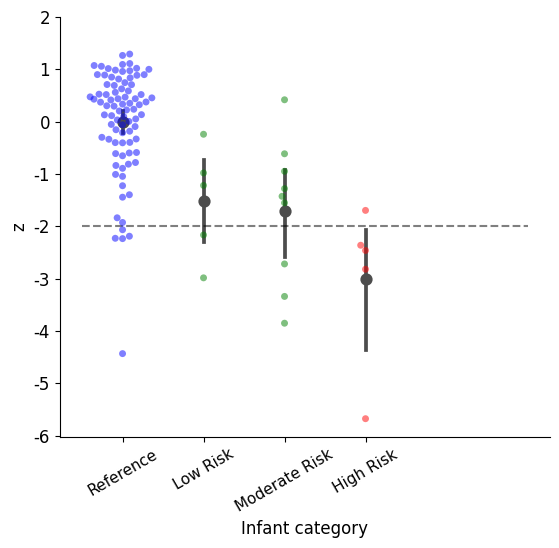

In [15]:
fig,ax=plt.subplots(nrows=1,ncols=1, figsize=(7,7))
fontsize=12

sns.swarmplot(ax=ax,x="risk", y="z", data=surprise, alpha=.5, dodge=False,zorder=100, palette=['b','g','g','r'])
sns.pointplot(ax=ax,x="risk", y="z", data=surprise, join=False, color=[.3,.3,.3],zorder=-1, estimator=np.mean)

ax.plot([-0.5,5], [-2]*2, alpha=.5,color=[0,0,0], ls='--')
ax.set_ylabel('z', fontsize=fontsize)
ax.set_xticks(np.arange(0,4))
ax.set_xticklabels(['Reference', 'Low Risk', 'Moderate Risk', 'High Risk'],fontsize=fontsize-1,rotation=30)
ax.set_yticks(np.arange(-6,3))
ax.set_yticklabels(np.arange(-6,3),fontsize=fontsize)

ax.set_xlabel('Infant category',fontsize=fontsize)
sns.despine()

fig.subplots_adjust(left=.2, bottom=.3, right=.9, top=.9, wspace=.2, hspace=.2)

mean_z = surprise.groupby('risk').mean(numeric_only=True)['z'].reset_index()
sd_z = surprise.groupby('risk').std(numeric_only=True)['z'].reset_index()

#print('mean z')
#print(np.around(mean_z.z,decimals=2))
#print('sd z')
#print(np.around(sd_z.z,decimals=2))